# Signal to noise calculations for the Australian Space Eye proposal

This notebook contains signal to noise calculations for the Australian Space Eye CubeSat space telescope proposal. The signal to noise/sensitivity are estimated for the main science aims of the mission, specifically absolute photometry of the Cosmic Infrared Background (CIB) and Zodiacal Light (ZL), and low surface brightness imaging of low redshift galaxies.

Two filter sets are considered:

1. 2 sets of 3 variant i and z band filters, designed to create 'virtual narrowband filters' in the Calcium triplet region in order to separate the CIB and ZL components.
1. 2 broadband i and z filters and 2 narrowband Calcium triplet 'on' and 'off' filters.

In each case each filter receives an equal share of the observing time.

## Standard imports

In [15]:
import sys
sys.path.append('..')

In [16]:
%matplotlib inline

In [141]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [18]:
from gunagala import imager

## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 3 variants of the Australian Space Eye concept and, for comparison, a 5 lens version of the Huntsman Telephoto Array.

In [241]:
imagers = imager.create_imagers()

huntsman = imagers['canon_sbig']  # A 5 lens array

ase_2016 = imagers['ase_2016']  # 6U with 1x 90 mm telescope & overlapping broadband filters
ase_2017 = imagers['ase_2017']  # 6U with 1x 90 mm telescope & broad and narrowband filters

waves_h = huntsman.wavelengths
waves_a = ase_2016.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Filter profiles 

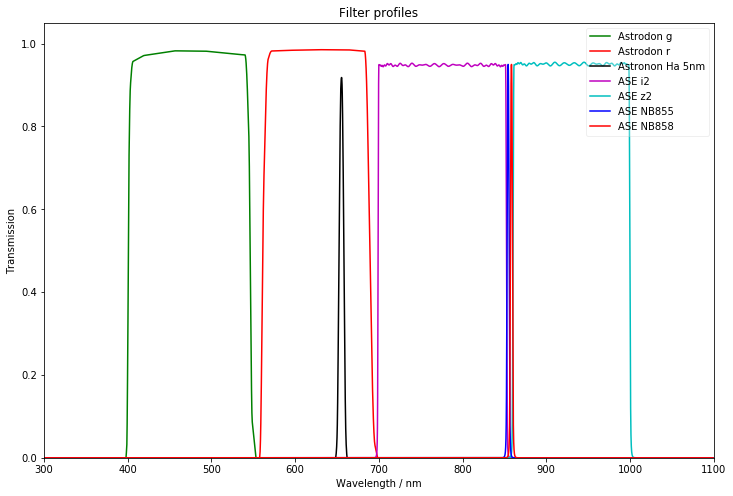

In [242]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'k-', label='Astronon Ha 5nm')
#plt.plot(waves_h, huntsman.filters['Ha_3nm'].transmission(waves_h), 'k-', label='Astronon Ha 3nm')


plt.plot(waves_a, ase_2017.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r-', label='ASE NB858')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(300, 1100)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [99]:
ase_2017.filters['ase_nb855'].FWHM

<Quantity 2.658233245264455 nm>

In [100]:
ase_2017.filters['ase_nb855'].lambda_c

<Quantity 854.3935690666981 nm>

In [101]:
ase_2017.filters['ase_nb858'].FWHM

<Quantity 2.666089320008723 nm>

In [102]:
ase_2017.filters['ase_nb858'].lambda_c

<Quantity 858.3907297645989 nm>

### Image sensor quantum efficiency

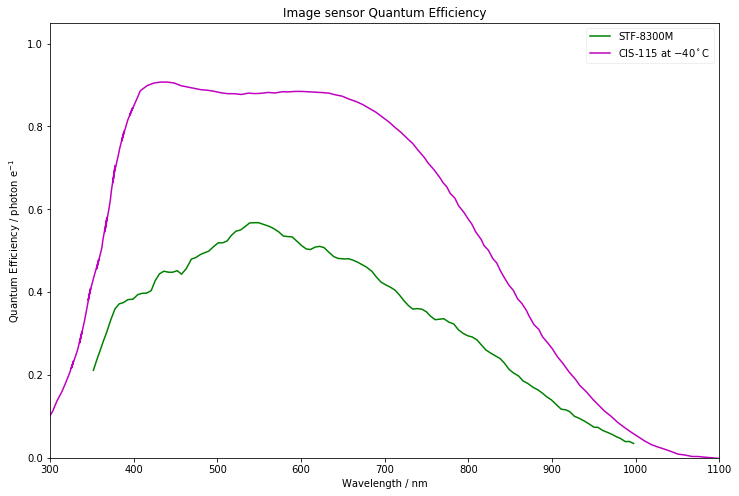

In [103]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')
plt.plot(ase_2017.camera.wavelengths, ase_2017.camera.QE, 'm-', label='CIS-115 at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,1.05)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

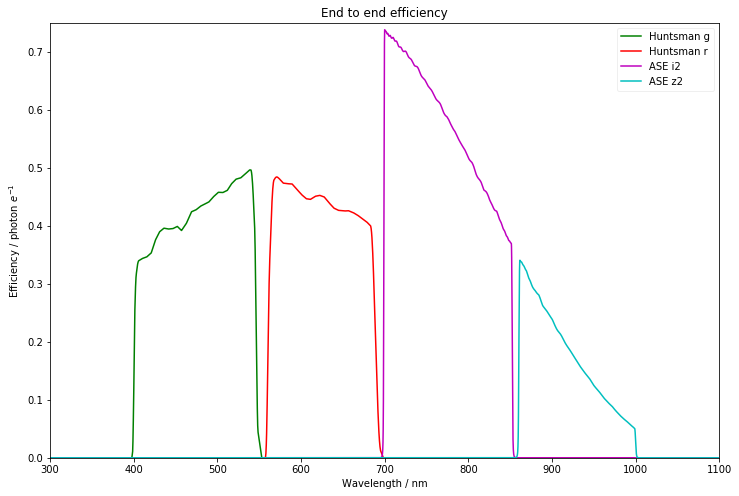

In [105]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Huntsman g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Huntsman r')

plt.plot(waves_a, ase_2017.efficiencies['ase_i1'], 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.efficiencies['ase_z3'], 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(300, 1100)
plt.ylim(0, 0.75)
plt.gcf().set_size_inches(12,8)

### Sky background model

For ASE the sky background is expected to dominated by the Zodiacal Light. For this we are use a scaled, reddened Solar spectrum following the prescription used by the HST ETC.

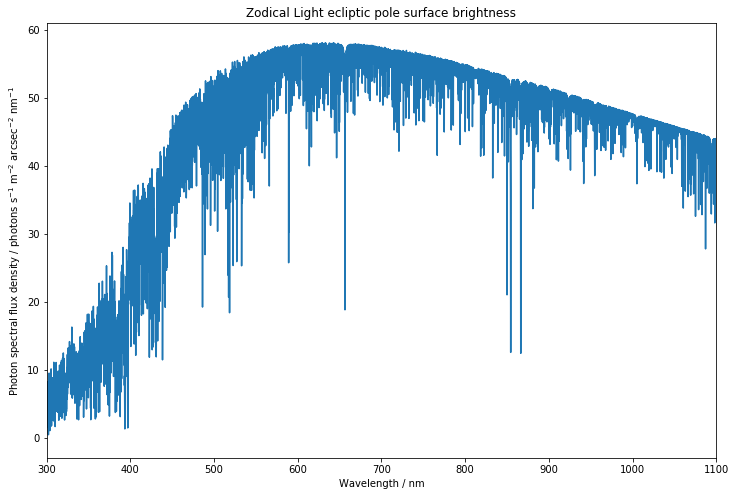

In [106]:
plt.plot(ase_2017.sky.waves.to(u.nm), ase_2017.sky.photon_sfd)
plt.xlim(300, 1100)
plt.title('Zodical Light ecliptic pole surface brightness')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12, 8)

### Filter transmission profile details


#### Virtual narrowband filter set

Close up of the blue edge of the 3 z band filter variants, shown together with the Zodiacal Light spectrum and its Calcium triplet absorption lines.

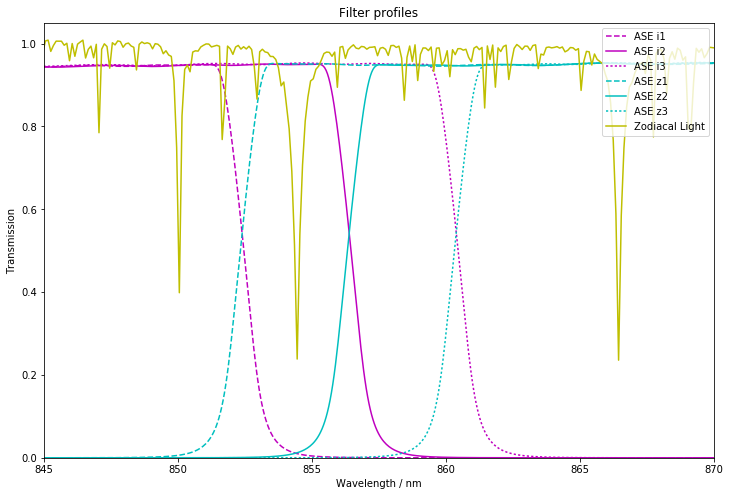

In [239]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm:', label='ASE i3')

plt.plot(waves_a, ase_2016.filters['ase_z1'].transmission(waves_a), 'c--', label='ASE z1')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c:', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 *ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The 'virtual narrowband filters' that result from the pair-wise differences between the 3 z band filters coincide with the strongest Ca-triplet absorption line and adjacent continuum.  Meaurements of the sky background in these 3 filters therefore allow a measurement of the depth of the Ca-triplet absorption.



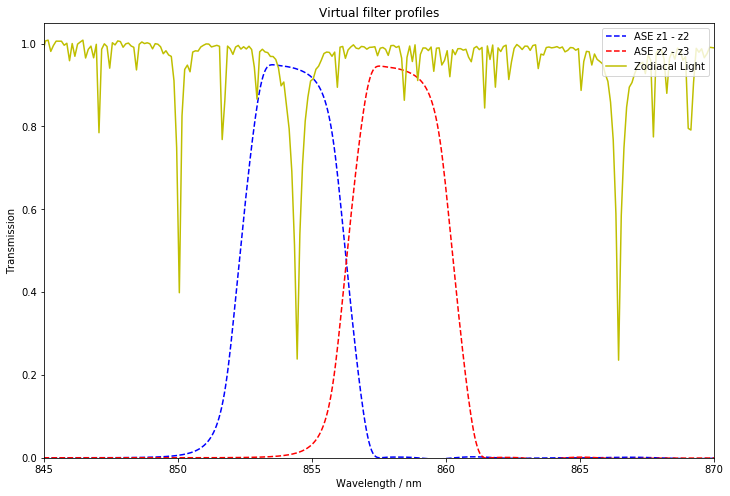

In [240]:
plt.plot(waves_a, 
         ase_2016.filters['ase_z1'].transmission(waves_a) - ase_2016.filters['ase_z2'].transmission(waves_a),
         'b--', label='ASE z1 - z2')
plt.plot(waves_a,
         ase_2016.filters['ase_z2'].transmission(waves_a) - ase_2016.filters['ase_z3'].transmission(waves_a),
         'r--', label='ASE z2 - z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

#### Standard filter set

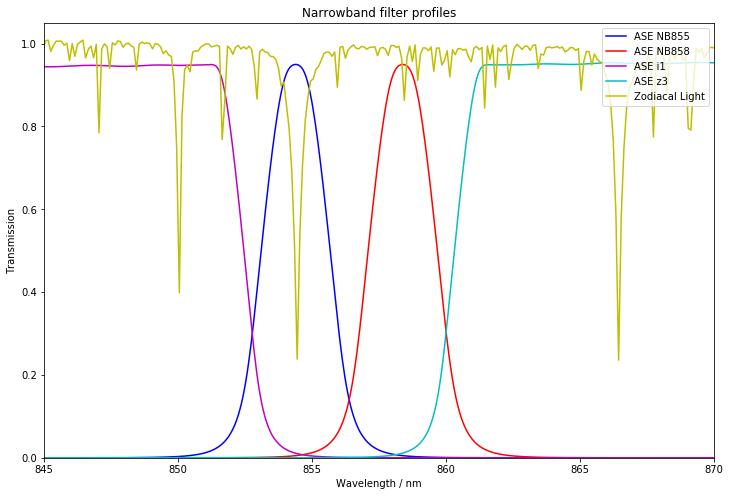

In [246]:
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r', label='ASE NB858')

plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Narrowband filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

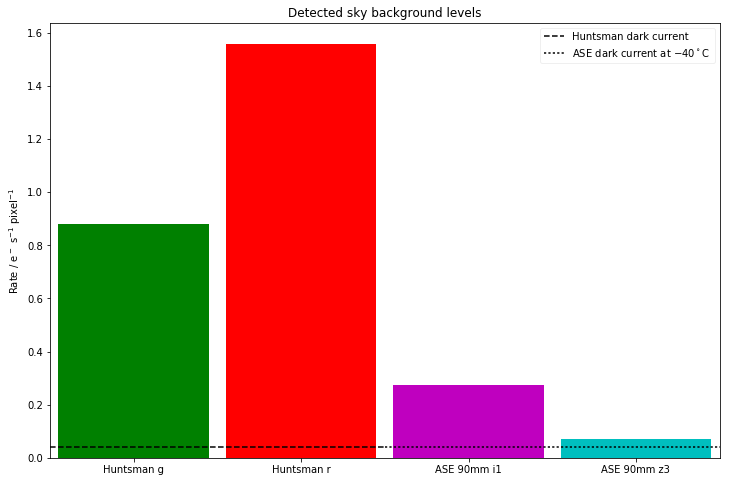

In [255]:
plt.bar((1, 2), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value),
        width=0.9, align='center', color=('g', 'r'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 2.5, linestyle='dashed', label='Huntsman dark current')

plt.bar((3, 4), (ase_2017.sky_rate['ase_i1'].value,
                       ase_2017.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'c'))
plt.hlines(ase_2017.camera.dark_current.value, 2.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)


plt.xticks((1, 2, 3, 4), 
           ('Huntsman g', 'Huntsman r', 'ASE 90mm i1', 'ASE 90mm z3'))
plt.xlim(0.5,4.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

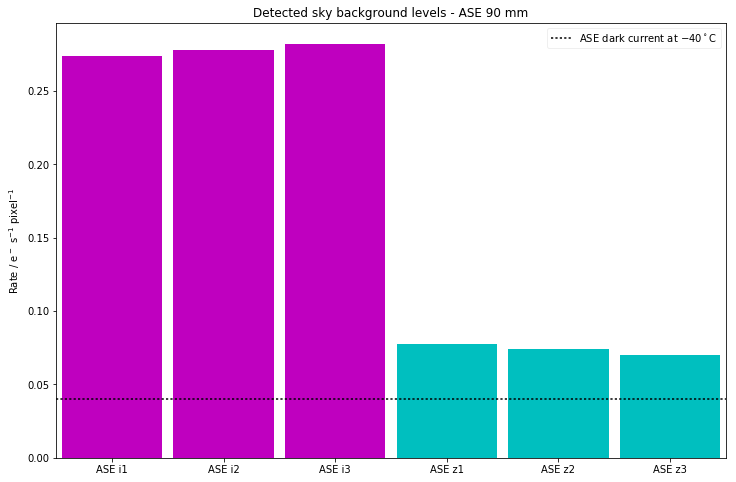

In [256]:
plt.bar((1, 2, 3, 4, 5, 6),
        (ase_2016.sky_rate['ase_i1'].value,
         ase_2016.sky_rate['ase_i2'].value,
         ase_2016.sky_rate['ase_i3'].value,
         ase_2016.sky_rate['ase_z1'].value,
         ase_2016.sky_rate['ase_z2'].value,
         ase_2016.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'm', 'm', 'c', 'c', 'c'))
plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,6.5)
plt.xticks((1, 2, 3, 4, 5, 6), ('ASE i1', 'ASE i2', 'ASE i3', 'ASE z1', 'ASE z2', 'ASE z3'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

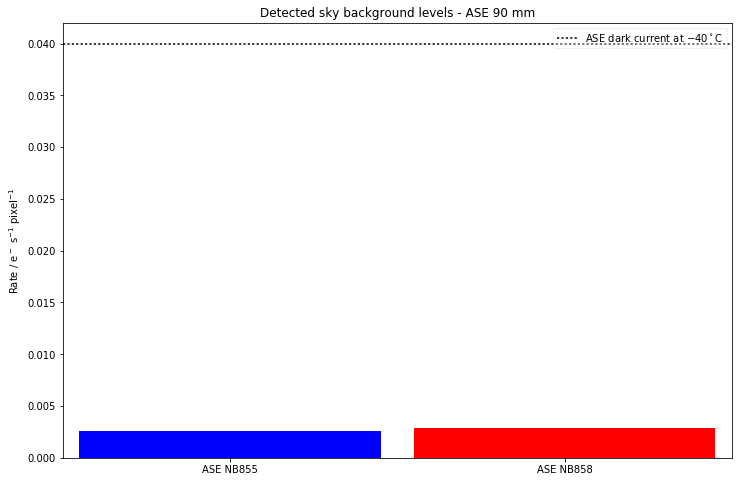

In [257]:
plt.bar((1, 2),
         (ase_2017.sky_rate['ase_nb855'].value,
          ase_2017.sky_rate['ase_nb858'].value),
          width=0.9, align='center', color=('b', 'r', 'b', 'r'))

plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,2.5)
plt.xticks((1, 2), ('ASE NB855', 'ASE NB858'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

## Broadband imaging sensitivity

For broadband i and z band imaging we combine the data from all the i band and all the z band filters together.

We expect to observe for approximately 40 minutes of each 100 minute orbit.  Individual sub exposures that therefore be up to 40 minutes long, cosmic rays permitting.

Nominal mission duration is 2 years, allowing up to several months on each target field.

In [258]:
duty_cycle = 40 / 100

### Basic extended source sensitivity, 1 month

Limiting surface brightness in AB magnitudes per square arcsecond given a signal to noise ratio threshold of 1.0 per arcsecond squared and 3 months on target.

#### Virtual narrowband filter set

Here we can consider the 3 variant i and 3 variant z filters to be essentially the same and sum them together. The effective fraction of total exposure time for either or i or z band is then 1/2.

In [259]:
filter_fraction = 3 / 6

##### i band

In [260]:
iasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')
iasv

<Magnitude 29.16394006789058 mag(AB)>

##### z band

In [261]:
zasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')
zasv

<Magnitude 28.177939931383378 mag(AB)>

#### Standard broadband filters

Here we have i, z, and 2 narrowband filters. Assuming each are given equal exposure time then each broadband filter gets 1/4 of the total exposure time.

In [262]:
filter_fraction = 1 / 4

##### i band

In [263]:
iasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')
iasb

<Magnitude 28.77819425410998 mag(AB)>

##### z band

In [264]:
zasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')
zasb

<Magnitude 27.757104061312695 mag(AB)>

#### Summary

In [265]:
t1 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iasv, iasb)),
                   u.Quantity((zasv, zasb))),
           names=('Filter set', 'i band', 'z band'))
t1.show_in_notebook(show_row_index=False)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,29.1639400679,28.1779399314
Standard broadband,28.7781942541,27.7571040613


### Extended source sensitivity, 1 months with binning

Our highest priority science targets will be very extended, allowing significant spatial binning after removal of compact source contaminants. For these a signal to noise threshold of, say, 1.0 per square _arcminute_ may be more appropriate than square arcsecond.  This is equivalent to an SNR of 1/60 per square arcsecond.

#### Virtual narrowband filter set

In [266]:
filter_fraction = 3 / 6

##### i band

In [267]:
iamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')
iamv

<Magnitude 33.61062018249179 mag(AB)>

##### z band

In [268]:
zamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')
zamv

<Magnitude 32.62545335392858 mag(AB)>

#### Standard broadband filters

In [269]:
filter_fraction = 1 / 4

##### i band

In [270]:
iamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')
iamb

<Magnitude 33.225424437936404 mag(AB)>

##### z band

In [271]:
zamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')
zamb

<Magnitude 32.20555394903401 mag(AB)>

#### Summary

In [272]:
t2 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iamv, iamb)),
                   u.Quantity((zamv, zamb))),
           names=('Filter set', 'i band', 'z band'))
t2.show_in_notebook(show_row_index=False)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,33.6106201825,32.6254533539
Standard broadband,33.2254244379,32.205553949


## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. ASE aims to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodical Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodical Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from ASE. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.



In [243]:
cib_brightness = 25 * u.ABmag
t_exp = 1 * 30 * u.day * duty_cycle * filter_fraction
t_sub = 40 * u.minute

virtual_nb_data = {}
filter_fraction = 1 / 6

for filter_name in ase_2016.filter_names:
    cib_signal, noise = ase_2016.extended_source_signal_noise(surface_brightness=cib_brightness,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per arcsecond squared')
    zl_signal, noise_again = ase_2016.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per arcsecond squared')
    virtual_nb_data[filter_name] = (cib_signal, zl_signal, noise)
    
standard_data = {}
filter_fraction = 1 / 4

for filter_name in ase_2017.filter_names:
    cib_signal, noise = ase_2017.extended_source_signal_noise(surface_brightness=cib_brightness,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per arcsecond squared')
    zl_signal, noise_again = ase_2017.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per arcsecond squared')
    standard_data[filter_name] = (cib_signal, zl_signal, noise)

In [244]:
virtual_nb_data

{'ase_i1': (<Quantity 9370.68616592637 electron / pix>,
  <Quantity 70980.96532739891 electron / pix>,
  <Quantity 304.05205392058326 electron / pix>),
 'ase_i2': (<Quantity 9503.05919269075 electron / pix>,
  <Quantity 71955.51873718068 electron / pix>,
  <Quantity 305.8669284670565 electron / pix>),
 'ase_i3': (<Quantity 9652.60239623906 electron / pix>,
  <Quantity 73154.00004390137 electron / pix>,
  <Quantity 308.0626599251205 electron / pix>),
 'ase_z1': (<Quantity 2476.7240486672317 electron / pix>,
  <Quantity 20171.0142453562 electron / pix>,
  <Quantity 186.39672286288575 electron / pix>),
 'ase_z2': (<Quantity 2338.5742186309385 electron / pix>,
  <Quantity 19153.507357846684 electron / pix>,
  <Quantity 183.27051474931153 electron / pix>),
 'ase_z3': (<Quantity 2208.503546861784 electron / pix>,
  <Quantity 18104.483270043853 electron / pix>,
  <Quantity 180.0249616495047 electron / pix>)}

In [245]:
standard_data

{'ase_i1': (<Quantity 9370.68616592637 electron / pix>,
  <Quantity 70980.96532739891 electron / pix>,
  <Quantity 304.05205392058326 electron / pix>),
 'ase_nb855': (<Quantity 96.06186907122715 electron / pix>,
  <Quantity 681.7590262759051 electron / pix>,
  <Quantity 113.4628613042485 electron / pix>),
 'ase_nb858': (<Quantity 92.24022336982489 electron / pix>,
  <Quantity 743.4217003983653 electron / pix>,
  <Quantity 113.71746534182068 electron / pix>),
 'ase_z3': (<Quantity 2208.503546861784 electron / pix>,
  <Quantity 18104.483270043853 electron / pix>,
  <Quantity 180.0249616495047 electron / pix>)}